In [18]:
import numpy as np
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import os
import glob
from sklearn.cluster import KMeans
import numpy as np
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC
from sklearn.multiclass import OneVsRestClassifier

# Assignment 5: Scene recognition with bag of words
[Instruction](https://mattabrown.github.io/425/assignments/Assignment5.html)
### Student name: Yeongu Choe
### Student number: 77672566

### SIFT review
* Usage: how computer understand which object it is from input image. For example, computer can recognize pencil from image.
* Advantage of SIFT: We can detect patch regardless of scale, rotation and partial occlusion.
#### Terminology
* Key point(Interest point): Unique area(blob) of the object in the image.
* SIFT feature descriptor
    * SIFT feature descriptor is a way to store information about the key point(area).
    * $\text{4 rows} \times \text{4 columns} \times \text{8 directions} = \text{128}$
    * Red vertical line represents the principle orientation.

### load()
* class == scene (e.g, Coast, Forest, Highway)

In [19]:
# API: return a list of image paths, a list of image labels and a list of scene(class) names
def load(ds_path):
    files = glob.glob(os.path.join(ds_path, "*", "*.txt"))
    n_files = len(files)
    image_paths = np.asarray(files)
    classes = glob.glob(os.path.join(ds_path, "*"))  # folder names
    labels = np.zeros(n_files)  # 0~14
    class_name_list = [x.split(os.sep)[-1] for x in classes]

    for i, path in enumerate(image_paths):
        # split relative path and file name
        directory_path, file_name = os.path.split(path)
        labels[i] = np.argwhere(
            np.core.defchararray.equal(classes, directory_path))[0, 0]

    # shuffle images
    idx = np.random.choice(n_files, size=n_files, replace=False)
    image_paths = image_paths[idx]
    labels = labels[idx]
    return image_paths, labels, class_name_list

In [20]:
train_image_paths, train_labels, train_scene_names = load("sift/train")
test_image_paths, test_labels, test_scene_names = load("sift/test")

## Question 4: 
<img src="notebook_image/bag_of_words.png" width="400">

* (code)word: similar image features (e.g, sea region, tree region); centroid(center of cluster)
* vocabulary: set of words(clusters)
* vocabulary size: number of clusters in k-means model

### k-means clustering
* The goal of K mean clustering is to cluster input SIFT feature descriptors into K clusters.
* Centroid: A feature descriptor which is the mean of all the SIFT feature descriptors within a cluster.
* Each SIFT feature descriptor is assigned to a cluster with the closest centroid.

$$
k\text{-means clustering} = 
\underset{\text{cluster membership}}{\text{argmin}} \ \overset{\text{Clusters}}{\sum}\ \overset{\text{SIFTs of cluster}}{\sum} ||\text{SIFT feature}-\text{centroid}||^2
$$

* Each cluster represent the item such as book, tree or car. Each cluster is also called code word.

### 4.1 build_vocabulary()
* API (what the function does)
    1. Sample feature(key point + SIFT)s from SIFT training images
    2. Group these features into clusters, using k-means clustering
    3. Return the model which will have information about the clustering.

#### Keypoints matrix
* The first two values of each row represent a key point.
$$
\begin{bmatrix}
x & y\newline
1 & 10\newline
3 & 2\newline
5 & 7\newline
13 & 37
\end{bmatrix}
$$

#### Feature descriptor matrix
* Each rows of the remaining part represent a feature descriptor.
* Each feature descriptor contains 128 elements.
$$
\begin{bmatrix}
36 & 6 & 2 & \cdots & 2 & 0 & 1\newline
7 & 0 & 7 & \cdots & 9 & 0 & 7\newline
56 & 32 & 4 & \cdots & 5 & 2 & 1\newline
9 & 1 & 4 & \cdots & 1 & 0 & 8\newline
\end{bmatrix}
$$


In [21]:
def build_vocabulary(image_paths: np.ndarray, vocab_size: int) -> KMeans:

    # Step1: count the number of image paths
    n_image = len(image_paths)
    # Step2: set the number of features to sample from each training image
    n_each = int(np.ceil(10000 / n_image))

    # Step3: initialize an array of features, which will store the sampled descriptors
    descriptors = np.zeros((n_image * n_each, 128))

    # Step4: loop over training images
    for index, path in enumerate(image_paths):
        # Structure of feature(row in features): [x, y, 128 dimension sift descriptor]
        # Step5: load SIFT features from a selected image
        features = np.loadtxt(path, delimiter=',', dtype=float)
        # Step6: select SIFT descriptor of image
        sift_descriptors = features[:, 2:]
        # Step7: sample n_each descriptors from sift_descriptor and store them into descriptors
        # From row index * n_each to (index + 1) * n_each in descriptors
        descriptors[index * n_each: (index + 1) * n_each] = sift_descriptors[np.random.choice(
            sift_descriptors.shape[0], size=n_each, replace=False)]

    # Step8: create a KMeans model with vocab_size clusters
    kmeans = KMeans(n_init=2, n_clusters=vocab_size).fit(descriptors)

    # Step9: return the KMeans model
    return kmeans

# Reference
# KMeans.fit(<samples>): enter sample data points(e.g, [[2,3],[3,4]]) into K means clustering.
# KMeans.predict(<new samples>): get the closest cluster number of new sample data points.

* I set the number of clusters to be 100.

In [22]:
number_of_words = 100
kmeans = build_vocabulary(train_image_paths, vocab_size=number_of_words)

### 4.2 get_bags_of_sifts()
* API: Return a $(\text{number of input images}) \times (\text{number of clusters})$ sized matrix, which
    * each row represents one image.
    * each column represents how many times that word appeared in that image.
$$
\text{image feats} = 
\begin{bmatrix}
\text{word(cluster)1} & \text{word(cluster)2} & \text{word(cluster)3} & \cdots \newline
7 & 0 & 7 & \cdots \newline
5 & 3 & 4 & \cdots \newline
9 & 1 & 4 & \cdots \newline
\end{bmatrix}
$$

In [23]:
def get_bags_of_sifts(image_paths: np.ndarray, kmeans: KMeans) -> np.ndarray:

    # Step1: count the number of image paths
    n_image = len(image_paths)
    # Step2: get the number of clusters in k-means model
    vocab_size = kmeans.cluster_centers_.shape[0]
    # Step3: Each row will contain occurrence distribution of words
    image_feats = np.zeros((n_image, vocab_size))

    # Step4: loop over (training/testing) images
    for index, path in enumerate(image_paths):
        # One image is selected
        # Step5: load SIFT features from a selected image
        features = np.loadtxt(path, delimiter=',', dtype=float)
        # Step6: select SIFT descriptor of selected image
        sift_descriptors = features[:, 2:]
        # Step7: assign each feature to the closest cluster(word)
        # The list will contain the closest word number of each SIFT feature descriptor (e.g, [word1,word3,word2,word1])
        centroids_of_descriptors = kmeans.predict(sift_descriptors)
        # Step8: count the occurrences of each centroid (visual word) in selected image
        # (e.g, [2,1,1])
        occurrence = np.bincount(
            centroids_of_descriptors, minlength=vocab_size)
        # Step9: count the number of SIFT descriptors in selected image
        number_of_descriptors = np.sum(occurrence)
        # Step10: divide the occurrence of words in image by the number of descriptors in image
        normalized_occurrence = occurrence / number_of_descriptors
        # Step11: store the normalized occurrence into a corresponding row in image_feats
        image_feats[index] = normalized_occurrence

    return image_feats

# numpy.bincount(<numbers>): count the occurerence of each integer in input array. (e.g, [0,0,0,1,1]->[3,2])

In [24]:
train_image_feats = get_bags_of_sifts(train_image_paths, kmeans)
test_image_feats = get_bags_of_sifts(test_image_paths, kmeans)

### 4.3 Visualize performance
* Plot average historam for each image category (Bedroom, Coast, Forest ...).
* Average histograms can be obtained by calculating average value of frequency on each direction over training images.

$$
\text{Histogram matrix} = 
\begin{bmatrix}
7 & 0 & 7 & \cdots \\
5 & 3 & 4 & \cdots \\
9 & 1 & 4 & \cdots \\
1 & 7 & 2 & \cdots \\
3 & 3 & 2 & \cdots \\
9 & 7 & 3 & \cdots \\
1 & 4 & 2 & \cdots \\
5 & 6 & 7 & \cdots \\
8 & 4 & 5 & \cdots \\
1 & 1 & 1 & \cdots \\
3 & 7 & 2 & \cdots \\
1 & 3 & 2 & \cdots \\
5 & 7 & 7 & \cdots \\
3 & 2 & 6 & \cdots \\
8 & 2 & 3 & \cdots \\
\end{bmatrix}
$$

#### Average BoW histograms

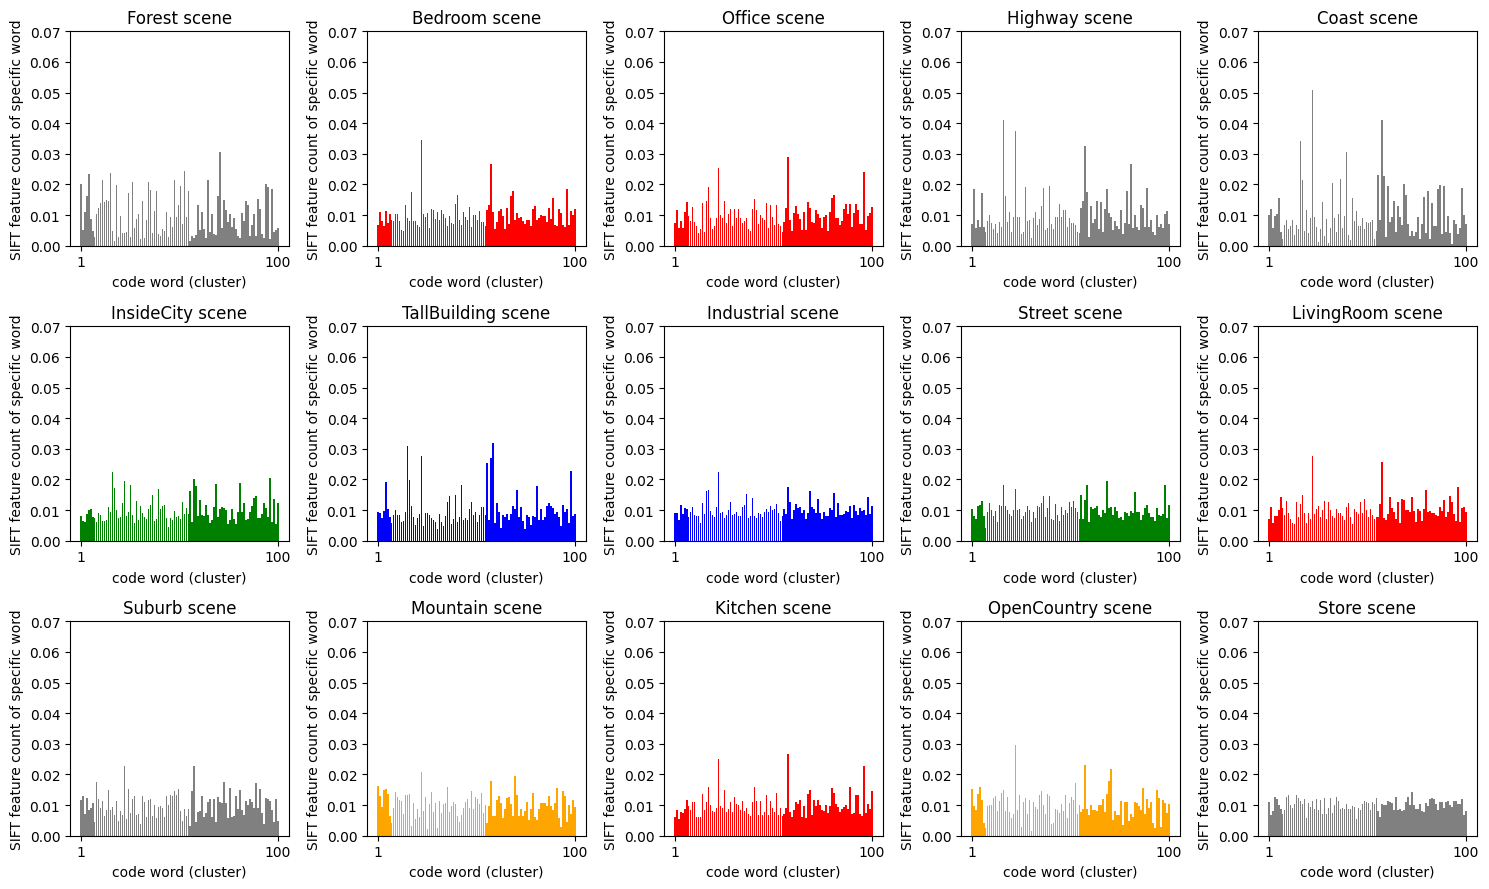

In [25]:
# Step1: Initialize histogram matrix
number_of_classes = 15
histogram_matrix = np.zeros((number_of_classes, number_of_words))
# Step2: List containing the number of training images in each class
number_of_images_in_each_class = [0] * 15
# Step3: Loop over all training images
number_of_training_images = len(train_labels)
for i in range(number_of_training_images):
    # Step4: Add SIFT descriptor distribution(codeword histogram) of selected image to corresponding class(row) in histogram matrix
    histogram_matrix[int(train_labels[i])] += train_image_feats[i]
    # Step6: Increment the number of training images in each class(row)
    number_of_images_in_each_class[int(train_labels[i])] += 1
# Step7: Divide each class in histogram matrix by the number of training images used in that class
for k in range(15):
    histogram_matrix[k] /= number_of_images_in_each_class[k]

# Display the histogram matrix
# Step8: Create 3x5 subplots
fig, axs = plt.subplots(3, 5, figsize=(15, 9))
# Step9: Loop over all classes
for k in range(15):
    # Step10: Plot histogram of each class
    subplot_row = k // 5
    subplot_column = k % 5
    bins = [i for i in range(1, number_of_words + 1)]
    counts = histogram_matrix[k]

    # Color the histogram same color if they have similar distribution
    if train_scene_names[k] in ['Bedroom', 'Office', 'LivingRoom', 'Kitchen']:
        axs[subplot_row, subplot_column].bar(bins, counts, color='red')
    elif train_scene_names[k] in ['InsideCity', 'Street']:
        axs[subplot_row, subplot_column].bar(bins, counts, color='green')
    elif train_scene_names[k] in ['TallBuilding', 'Industrial']:
        axs[subplot_row, subplot_column].bar(bins, counts, color='blue')
    elif train_scene_names[k] in ['OpenCountry', 'Mountain']:
        axs[subplot_row, subplot_column].bar(bins, counts, color='orange')
    # If histograms are not similar, color them grey
    else:
        axs[subplot_row, subplot_column].bar(bins, counts, color='grey')

    axs[subplot_row, subplot_column].set_ylabel(
        'SIFT feature count of specific word')
    axs[subplot_row, subplot_column].set_ylim([0, 0.07])
    axs[subplot_row, subplot_column].set_xlabel('code word (cluster)')
    axs[subplot_row, subplot_column].set_xticks([1, number_of_words])
    axs[subplot_row, subplot_column].set_title(f'{train_scene_names[k]} scene')

# Step11: Display the plot
plt.tight_layout()
plt.show()

### 4.4 Histogram analysis
* I created a histogram illustrating the frequency of words in each scene. Afterward, I identified the following patterns:
    1. First, the distribution of words in the bedroom, office, living room, and kitchen classes is similar.
    2. Second, inside city and street classes have a similar distribution.
    3. Third, the tall building and industrial classes have a similar distribution.
    4. Lastly, the mountain and open country classes have a similar distribution.

## Question 5: Classifying image with k-nearest neighbors algorithm
* Classifier function: a function that takes features as input and outputs the class labels to which those features belong.
* e.g, [Feature1, Feature2, Feature3]->class 3 (Coast scene)

### 5.1 nearest_neighbor_classify()
* API: Return predicted labels for test images using feature(keypoint+SIFT)s of each image.

In [26]:
def nearest_neighbor_classify(train_image_feats: np.ndarray, train_labels: np.ndarray, test_image_feats: np.ndarray) -> np.ndarray:
    # Step1: set k for KNN
    k = 15
    # Step2: initialize KNN classifier
    neigh = KNeighborsClassifier(n_neighbors=k)
    # Step3: train KNN classifier
    neigh.fit(X=train_image_feats, y=train_labels)  # X: data points, y: labels
    # Step4: predict labels of test data
    one_hot_vectors = neigh.predict(test_image_feats)
    predicted_labels = one_hot_vectors
    # Step5: return predicted labels
    return predicted_labels

In [27]:
# Step1: get the predicted labels using KNN
pred_labels_knn = nearest_neighbor_classify(
    train_image_feats, train_labels, test_image_feats)

### 5.2 Performance Analysis of KNN classifier

#### 5.2.1 Accuracy score of KNN classifier

In [28]:
# Step1: Get accuracy score when using KNN
accuracy_knn = accuracy_score(test_labels, pred_labels_knn)
print(f"Accuracy score of KNN classifier: {accuracy_knn}")

Accuracy score of KNN classifier: 0.37555555555555553


#### 5.2.2 Confusion matrix of KNN classifier

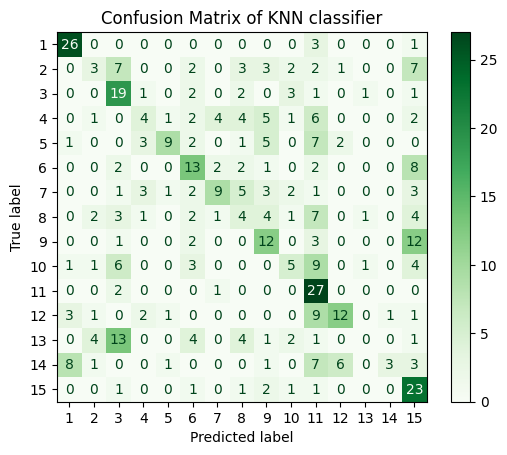

In [29]:
# Step1: matrix of predicted labels using KNN
predicted = pred_labels_knn
# Step2: matrix of actual labels
actual = test_labels
# Step3: computer confusion matrix
cm = confusion_matrix(actual, predicted)
# Step4: display confusion matrix
display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[
    i for i in range(1, 16)])
display.plot(cmap='Greens')
plt.title('Confusion Matrix of KNN classifier')
plt.show()

#### 5.2.3 K nearest neighbor analysis
<img src="notebook_image/knn_analysis.png" width=400>

* In K nearest neighbors, The value of $k$ is used for two purposes: 
    * First, to create clusters using the training data.
    * Second, to classify the test data by selecting the $k$ nearest points from clusters.
* A particular $k$ value resulted in the highest accuracy score. In the current configuration, $k=15$ yielded the highest accuracy score.

## Question 6: Classifying image with linear support vector machine

### 6.1 svm_classify()
* API: Return predicted labels of test data using SVM classifier

In [30]:
def svm_classify(train_image_feats: np.ndarray, train_labels: np.ndarray, test_image_feats: np.ndarray) -> np.ndarray:
    # Step1: initialize 1-vs-all linear SVM classifier
    clf = OneVsRestClassifier(LinearSVC(C=50, dual="auto"))
    # Step2: train the linear SVM classifier
    clf.fit(X=train_image_feats, y=train_labels)
    # Step3: predict labels of test data
    one_hot_vectors = clf.predict(test_image_feats)
    predicted_labels = one_hot_vectors
    # Step4: return predicted labels
    return predicted_labels

In [31]:
# Step1: get the predicted labels using SVM
pred_labels_svm = svm_classify(
    train_image_feats, train_labels, test_image_feats)

### 6.2 Performance Analysis of SVM classifier

#### 6.2.1 Accuracy score of SVM classifier

In [32]:
# Step1: Get accuracy score when using SVM
accuracy_svm = accuracy_score(test_labels, pred_labels_svm)
print(f"Accuracy score of SVM classifier: {accuracy_svm}")

Accuracy score of SVM classifier: 0.4866666666666667


#### 6.2.2 Confusion matrix of SVM classifier

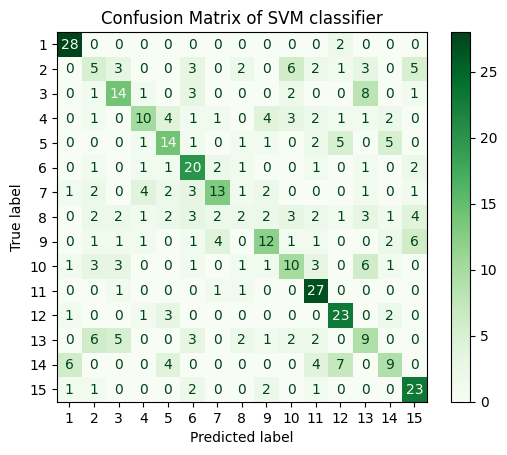

In [33]:
# Step1: matrix of predicted labels using KNN
predicted = pred_labels_svm
# Step2: matrix of actual labels
actual = test_labels
# Step3: compute confusion matrix
cm = confusion_matrix(actual, predicted)
# Step4: display confusion matrix
display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[
    i for i in range(1, 16)])
display.plot(cmap='Greens')
plt.title('Confusion Matrix of SVM classifier')
plt.show()

#### 6.2.3 Support vector machine analysis
<img src="notebook_image/svm_analysis.png" width="400">

* In a support vector machine, C denotes the regularization strength. The value $\frac{1}{C}$ determines the upper bound distance between classification regions.
* If the upper bound for distance is set high with a low value of C, there is a high chance of overfitting. Conversely, if the upper bound for distance is set low with a high value of C, there is a low chance of overfitting.
* A specific value of $C$ resulted in the highest accuracy. In the current setup, $C=50$ produced the highest accuracy score.

### Table of accuracy
* This table presents the accuracy scores obtained using the k-nearest neighbor (KNN) classifier and the support vector machine (SVM) classifier.

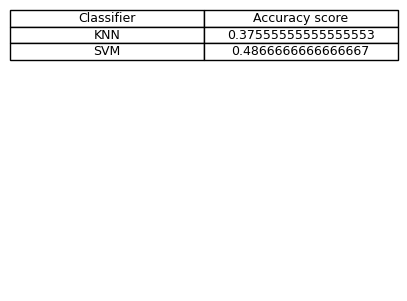

In [34]:
table_data = [
    ['Classifier', 'Accuracy score'],
    ['KNN', accuracy_knn],
    ['SVM', accuracy_svm],
]
plt.figure(figsize=(5, 3))
accuracy_table = plt.table(
    cellText=table_data, loc='top', cellLoc='center', colLabels=None)
ax = plt.gca()
ax.axis('off')

plt.show()